In [174]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [175]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [176]:
max_features = 1000000 # max vocab size

Vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_features,output_mode= 'tf_idf', ngrams=2)

Vectorizer.adapt(np.array(train_df['text']))

#vocab = Vectorizer.get_vocabulary()
#num_tokens = len(vocab)
#print(vocab)

In [177]:
model = tf.keras.Sequential([
    Vectorizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [178]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(1e-3),
             metrics=['accuracy'])

In [179]:
X = train_df['text']
y = train_df['author']

authors_bool = []

for i in y:
    if i == 'EAP':   authors_bool.append([1,0,0])
    elif i == 'HPL': authors_bool.append([0,1,0])
    elif i == 'MWS': authors_bool.append([0,0,1])        
        
X_train, X_test, y_train, y_test = train_test_split(
    X, authors_bool, test_size=0.33, shuffle=True, random_state = 13)

In [180]:
history = model.fit(list(X_train), list(y_train), epochs=5, batch_size=32,
                         validation_data=(list(X_test), list(y_test)),
                         validation_steps=10)

Epoch 1/5
410/410 [==============================] - 21s 49ms/step - loss: 0.5555 - accuracy: 0.7747 - val_loss: 0.3952 - val_accuracy: 0.8406
Epoch 2/5
410/410 [==============================] - 19s 46ms/step - loss: 0.0319 - accuracy: 0.9941 - val_loss: 0.4056 - val_accuracy: 0.8375
Epoch 3/5
410/410 [==============================] - 19s 46ms/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 0.4296 - val_accuracy: 0.8313
Epoch 4/5
410/410 [==============================] - 20s 49ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.4480 - val_accuracy: 0.8281
Epoch 5/5
410/410 [==============================] - 20s 48ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.4622 - val_accuracy: 0.8313


In [181]:
predictions = model.predict(X_test)
predictions

array([[7.3137634e-02, 2.2567621e-01, 7.0118612e-01],
       [7.2190888e-02, 9.2698961e-01, 8.1948499e-04],
       [3.9643169e-04, 6.1843294e-01, 3.8117066e-01],
       ...,
       [6.8391174e-01, 3.7414517e-02, 2.7867368e-01],
       [8.4109271e-01, 5.9719525e-02, 9.9187724e-02],
       [7.9937834e-01, 1.9416717e-01, 6.4544743e-03]], dtype=float32)

In [182]:
pred_bool = []

for pred in predictions:
    pred = list(pred)
    max_index = pred.index(max(pred))
    
    for i in range(len(pred)):
        if i == max_index: 
            pred[i] = 1
        else: 
            pred[i] = 0
    pred_bool.append(pred)

In [183]:
def confusion(predictions, test_labels):
    matrix = np.zeros([3,3], dtype=int)
    
    for i, row in enumerate(predictions):
        matrix[np.argmax(row), np.argmax(test_labels[i])] += 1
    
    return matrix


confusion(predictions, y_test)     

array([[2177,  194,  198],
       [ 144, 1500,   57],
       [ 283,  167, 1742]])

Text(33.0, 0.5, 'True')

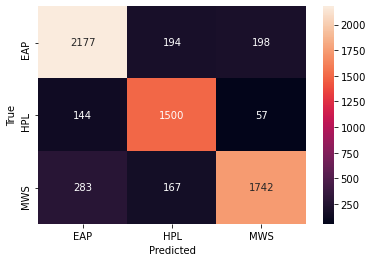

In [184]:
import seaborn as sns

x_axis_labels = ['EAP', 'HPL', 'MWS']
y_axis_labels = ['EAP', 'HPL', 'MWS']

ax = sns.heatmap(confusion(predictions, y_test), xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [185]:
mat = confusion(predictions, y_test)

precisions, recalls, f1s = [],[],[]

for i in range(len(mat)):
    row = mat[i]
    col = mat[:,i]
    
    p = row[i] / (sum(row))
    r = col[i] / sum(col)
    f = 2 * ((precision * recall) / (precision + recall))
    
    precisions.append(p)
    recalls.append(r)
    f1s.append(2 * ((p * r) / (p + r)))

In [186]:
data = {'precision':precisions,
        'recall':recalls,
        'f1 score':f1s}
 
df = pd.DataFrame(data, index =['EAP','HPL','MWS'])
df

,precision,recall,f1 score
EAP,0.847411,0.836022,0.841678
HPL,0.881834,0.806018,0.842223
MWS,0.794708,0.872308,0.831702


In [187]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [188]:
test_preds = model.predict(test_df['text'])

In [189]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'EAP': test_preds[:,0],
    'HPL': test_preds[:,1],
    'MWS': test_preds[:,2]
})
submission

,id,EAP,HPL,MWS
0,id02310,0.000635,4.590013e-03,9.947747e-01
1,id24541,1.000000,1.737929e-08,3.327960e-09
2,id00134,0.000085,9.998343e-01,8.120575e-05
3,id27757,0.230698,3.461823e-01,4.231200e-01
4,id04081,0.217576,2.772320e-01,5.051923e-01
...,...,...,...,...
8387,id11749,0.359301,2.883799e-02,6.118606e-01
8388,id10526,0.001298,1.193023e-02,9.867715e-01
8389,id13477,1.000000,1.667420e-07,6.204004e-08
8390,id13761,0.026362,4.888224e-05,9.735895e-01


In [190]:
submission.to_csv('submission.csv', index=False)